In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba.experimental import jitclass
from scipy.ndimage import laplace
import time
%matplotlib tk

In [3]:
class IVP():
    
    def __init__(self, val, case):
        """
        for CH values should be list in order phi,M,k,a,dimensions
        for Poisson values should be list in order 0,dimensions
        """
        self.I = val
        #self.rand = 
        self.grid = self.I[0]*np.ones(100*(np.ones(self.I[-1], dtype=int))) + 0.1*(0.5-np.random.rand(*(np.ones((100*np.ones(self.I[-1], dtype=int)))).shape))
        #self.grid2 = self.grid
        self.p = np.zeros_like(self.grid)
        self.N = 100
        
        if case == "cahn":
            self.a = val[3]
            self.M = val[1]
            self.k = val[2]
        
        
    def cahnhilliard(self,dt=1,dx=1):
        """
        euler update for cahn hilliard
        """
        phi, M, k, a, n = self.I
        copy = np.copy(self.grid)
        mu = -self.a*copy+self.a*copy**3-self.k*(dt/dx**2)*(np.roll(copy,1,axis=0)
            + np.roll(copy,-1,axis=0) + np.roll(copy,1,axis=1) + np.roll(copy,-1,axis=1)
            -(4*copy))
        self.grid = self.grid + M*(dt/dx**2)*(np.roll(mu,1,axis=0)+np.roll(mu,-1,axis=0)+np.roll(mu,1,axis=1)+np.roll(mu,-1,axis=1)-(4*mu))
        
    
    def cahncycle(self,n=300000):
        nrange = np.arange(0,n,1)
        freeen = []
        for i in range(n):
            self.cahnhilliard()
            free = self.FreeEn()
            freeen.append(free)
            if i%5000 ==0:
                plt.cla()
                im = plt.imshow(self.grid, animated=True)
                plt.draw()
                plt.pause(0.001)
            if i%50000 == 0:
                print(i)
                
        return nrange, freeen
                
    def FreeEn(self):
        copy = np.copy(self.grid)
        fdense = -(self.a/2)*copy**2+(self.a/4)*copy**4+(self.k/(2))*(np.gradient(copy)[0]**2+np.gradient(copy)[1]**2)
        f = np.sum(fdense)
        return f
            
    def boundary(self, x):
        x[0,:,] = x[:,0,:] = x[:,:,0] = x[-1,:,] = x [:,-1,:] = x[:,:,-1] = 0
        
    def pointcharge(self):
        N = self.N
        self.p[int(N/2),int(N/2),int(N/2)] = 1
        
    def jacobi(self, n):
       
        N = self.grid.shape[0]
        self.grid = np.zeros_like(self.grid)
        charge = np.zeros_like(self.grid)
        charge[int(N/2), int(N/2), int(N/2)] = 1
        
        #print(self.grid)
        #psi = np.copy(self.grid)
        for i in range(n):
            psi = np.copy(self.grid)
            self.grid = (1/6)*(np.roll(psi,1, axis=0) + np.roll(psi,-1, axis=0) 
                               +np.roll(psi,1, axis=1) + np.roll(psi, -1, axis=1) + 
                               np.roll(psi,1, axis=2) + np.roll(psi,-1, axis=2)
                               + charge)
            self.boundary(self.grid)
            plt.cla()
            #plt.colorbar()
            im = plt.contourf(self.grid[:,int(N/2),:], animated=True)
            plt.draw()
            plt.pause(0.001)
    #@staticmethod
    #@jit(nopython=True)        
        
    
                
    def relax(self):
        N = self.N
        om = np.arange(1,2,0.01)
        sweep = []
        mask = np.indices((N,N,N)).sum(axis=0)%2
        self.pointcharge()
        
        for i in om:
            t1 = time.time()
            self.grid = np.zeros((N,N,N))
            self.pointcharge()
            convergence = 0.3
            conv = convergence + 1
            sum1=0
            temp=0
            copy = np.copy(self.grid)
            
            while(conv>convergence):
                vals = np.copy(self.grid)
                self.grid[mask==0]=0
                self.grid = (1-i)*vals + i*((1/6)*(np.roll(self.grid,1,axis=0) + np.roll(self.grid,-1,axis=0) 
                              + np.roll(self.grid,1,axis=1) + np.roll(self.grid,-1,axis=1)
                              + np.roll(self.grid,1,axis=2) + np.roll(self.grid,-1,axis=2) + self.p))
    
                                            
                self.boundary(self.grid)

                self.grid[mask==1]=0
                #copy = (1-i)*vals + i*((1/6)*(np.roll(copy,1,axis=0) + np.roll(copy,-1,axis=0) 
                #              + np.roll(copy,1,axis=1) + np.roll(copy,-1,axis=1)
                #              + np.roll(copy,1,axis=2) + np.roll(copy,-1,axis=2) + self.p))
                copy = (1-i)*vals + i*((1/6)*(np.roll(self.grid,1,axis=0) + np.roll(self.grid,-1,axis=0) 
                              + np.roll(self.grid,1,axis=1) + np.roll(self.grid,-1,axis=1)
                              + np.roll(self.grid,1,axis=2) + np.roll(self.grid,-1,axis=2) + self.p))
                self.boundary(copy)
                                       
                copy[mask==0]=0
                self.grid=np.add(self.grid,copy)
                sum2=np.sum(self.grid)
                #print("sum2 is " + str(sum2))
                conv = abs(sum2)-abs(sum1)
                temp+=1
                if(temp%100==0):
                    print(f"Temp={temp} convergence={conv} sum1={sum1}  sum2={sum2}  ")       
                sum1 = sum2
            sweep.append(temp)
        
        plt.plot(om,sweep)
        plt.scatter(om,sweep)
        plt.xlabel("omega")
        plt.ylabel("Sweeps")
        plt.show()
        print("Minimum at " + str(np.min(sweep)))
                        
                    
        
    def Ex(self,i,j,k):
        
        """
        Calculates field in given direction
        """
        N = self.grid.shape[0]
        
        
        gradient = self.grid[(i+1)%N,j,k]- self.grid[(i-1)%N,j,k]
        return -gradient/2

    def Ey(self,i,j,k):
        """
        Calculates field in given direction
        """
        N = self.grid.shape[0]
        
        gradient = self.grid[i,(j+1)%N,k]- self.grid[i,(j-1)%N,k]
        return -gradient/2

    def Ez(self,i,j,k):
        """
        Calculates field in given direction
        """
        N = self.grid.shape[0]
       
        gradient = self.grid[i,j,(k+1)%N]- self.grid[i,j,(k-1)%N]
        return -gradient/2

    def efield(self):
        N = self.grid.shape[0]
        #e = np.gradient(self.grid)
        xGrad = np.zeros((N,N))
        yGrad = np.zeros((N,N))
        zGrad = np.zeros((N,N))
        mid =int(N/2)
        for i in range(1,N-1):
            for j in range(1,N-1):
                xGrad[i,j] = self.Ex(i,j,mid)
                yGrad[i,j] = self.Ey(i,j,mid)
                zGrad[i,j] = self.Ez(i,j,mid)
        normarray = np.zeros_like(self.grid)
        for i in range(1,N-1):
            for j in range(1,N-1):
                normalise = np.sqrt((xGrad[i,j]**2) + (yGrad[i,j]**2) + (zGrad[i,j]**2))
                xGrad[i,j]= xGrad[i,j]/normalise
                yGrad[i,j]= yGrad[i,j]/normalise
        
        #plt.imshow(e[0][:,int(N/2),:])
        ranges = np.arange(0,N,1)
        x,y = np.meshgrid(ranges,ranges)
        #plt.quiver(y,x,xGrad,yGrad)
        plt.quiver(y[40:60,40:60],x[40:60,40:60],xGrad[40:60,40:60],yGrad[40:60,40:60])
        plt.savefig("efield.png")
        #ax = plt.quiver(e[1][:,:,int(N/2)][40:60,40:60],e[0][:,:,int(N/2)][40:60,40:60])
        #ax = plt.quiver(-1*e[0][:,int(N/2),:], -1*e[1][:,int(N/2),:])
    
    def Bx(self,i,j,k):
        """
        Calculates field in given direction
        """
        N = self.N
        curl = self.grid[i,(j+1)%N,k]- self.grid[i,(j-1)%N,k]
        return -curl/2
    
    def By(self,i,j,k):
        """
        Calculates field in given direction
        """
        N = self.N
        curl = -(self.grid[(i+1)%N,j,k]- self.grid[(i-1)%N,j,k])
        return -curl/2

        
    def bfield(self):
        
        N = self.grid.shape[0]
        #e = np.gradient(self.grid)
        xGrad = np.zeros((N,N))
        yGrad = np.zeros((N,N))
        mid =int(N/2)
        for i in range(1,N-1):
            for j in range(1,N-1):
                xGrad[i,j] = self.Bx(i,j,mid)
                yGrad[i,j] = self.By(i,j,mid)
        normarray = np.zeros_like(self.grid)
        for i in range(1,N-1):
            for j in range(1,N-1):
                normalise = np.sqrt((xGrad[i,j]**2) + (yGrad[i,j]**2))
                xGrad[i,j]= xGrad[i,j]/normalise
                yGrad[i,j]= yGrad[i,j]/normalise
        
        #plt.imshow(e[0][:,int(N/2),:])
        ranges = np.arange(0,N,1)
        x,y = np.meshgrid(ranges,ranges)
        #plt.quiver(y,x,xGrad,yGrad)
        plt.quiver(y[40:60,40:60],x[40:60,40:60],xGrad[40:60,40:60],yGrad[40:60,40:60])
          
            
        
    
    def wire(self):
        N = self.grid.shape[0]
        charge = np.zeros_like(self.grid)
        self.grid = np.zeros_like(self.grid)
        for i in range(1,N-1):
            charge[int(N/2),int(N/2),i]=1
        
        #red = np.ones_like(self.grid)
        #black = np.ones_like(self.grid)
        #red[1::2, 1::2, 1::2] = red[1::2,::2,::2] = red[::2,1::2,::2] = red[::2,::2,1::2] = False
        #black[1::2, ::2, 1::2] = red[1::2,1::2,::2] = red[::2,::2,::2] = red[::2,::2,::2] = False
        mask = np.indices((N,N,N)).sum(axis=0)%2
        convergence = 1
        conv = convergence + 1
        temp = 0
        total = np.sum(self.grid)
        copy = np.copy(self.grid)
        self.boundary(self.grid)
        while(conv>=convergence):
            ti = time.time()
            self.grid[mask==0]=0
            self.grid = (1/6)*(np.roll(self.grid,1,axis=0) + np.roll(self.grid,-1,axis=0) 
                              + np.roll(self.grid,1,axis=1) + np.roll(self.grid,-1,axis=1)
                              + np.roll(self.grid,1,axis=2) + np.roll(self.grid,-1,axis=2) + charge)
            self.boundary(self.grid)
            self.grid[mask==1]=0
            copy = (1/6)*(np.roll(self.grid,1,axis=0) + np.roll(self.grid,-1,axis=0) 
                              + np.roll(self.grid,1,axis=1) + np.roll(self.grid,-1,axis=1)
                              + np.roll(self.grid,1,axis=2) + np.roll(self.grid,-1,axis=2) + charge)
            self.boundary(copy)
            self.grid= (np.add(self.grid,copy))
            total2 = np.sum(self.grid)
            conv = abs(total2)-abs(total)
            temp+=1
            total=total2
            if(temp%1000==0):
                print(f"Counter={temp} convergence={conv} time={time.time()-ti}s")
        #print(self.grid[:,:,int(N/2)])
        ranges=np.arange(0,N,1)
        x,y = np.meshgrid(ranges,ranges)
        plt.contourf(y,x,self.grid[:,:,int(N/2)])
        plt.savefig("wirefield.png")
        #plt.colorbar()
        print(temp,conv)
        
    def gausspoint(self, convergence=0.05):
        N = self.N
        self.pointcharge()
        print(N)
        mask=np.indices((N,N,N)).sum(axis=0)%2
        conv = convergence + 1
        temp = 0
        total = np.sum(self.grid)
        copy = np.copy(self.grid)
        
        while(conv>=convergence):
            ti = time.time()
            self.grid[mask==0]=0
            self.grid = (1/6)*(np.roll(self.grid,1,axis=0) + np.roll(self.grid,-1,axis=0) 
                              + np.roll(self.grid,1,axis=1) + np.roll(self.grid,-1,axis=1)
                              + np.roll(self.grid,1,axis=2) + np.roll(self.grid,-1,axis=2) + self.p)
            self.boundary(self.grid)
            self.grid[mask==1]=0
            copy = (1/6)*(np.roll(self.grid,1,axis=0) + np.roll(self.grid,-1,axis=0) 
                              + np.roll(self.grid,1,axis=1) + np.roll(self.grid,-1,axis=1)
                              + np.roll(self.grid,1,axis=2) + np.roll(self.grid,-1,axis=2) + self.p)
            self.boundary(copy)
            self.grid= (np.add(self.grid,copy))
            total2 = np.sum(self.grid)
            conv = abs(total2)-abs(total)
            temp+=1
            total=total2
            if(temp%400==0):
                print(f"Counter={temp} convergence={conv} time={time.time()-ti}s")
        #print(self.grid[:,:,int(N/2)])
        ranges=np.arange(0,N,1)
        plt.imshow(self.grid[:,:,int(N/2)])
        plt.savefig("pointcharge.png")
        #plt.colorbar()
        print(temp,conv)
        
    def centerdistance(self,i,j,k):
        N = self.N
        distance = np.sqrt((int(N/2)-i)**2 + (int(N/2) -j)**2 + (int(N/2)-k)**2)
        return distance
        
    def dataefield(self):
        N= self.N
        x = []
        y = []
        z = []
        potential = []
        ex = []
        ey = []
        ez = []
        slic = self.grid[:,:,int(N/2)]
        distance = []
        efieldmag = []
        for i in range(1, N-1):
            for j in range(1,N-1):
                potential.append(slic[i,j])
                x.append(i)
                y.append(j)
                z.append(int(N/2))
                ex.append(self.Ex(i,j,int(N/2)))
                ey.append(self.Ey(i,j,int(N/2)))
                ez.append(self.Ez(i,j,int(N/2)))
                distance.append(self.centerdistance(i,j,int(N/2)))
                efieldmag.append(np.sqrt(self.Ex(i,j,int(N/2))**2 + self.Ey(i,j,int(N/2))**2 + self.Ez(i,j,int(N/2))**2))
                                   
        positiondata = np.array((x,y,z, potential,ex,ey,ez))
        distancedata = np.array((distance, potential, efieldmag))
        np.savetxt(f"potentialDataposition_{N}.dat",np.transpose(positiondata), fmt='%s')
        np.savetxt(f"potentialDatadistance_{N}.dat",np.transpose(distancedata), fmt='%s')
    
    
    def databfield(self):
        N = self.N
        x = []
        y = []
        potential = []
        bx = []
        by = []
        distance = []
        normb = []
        slic = self.grid[:,:,int(N/2)]
        
        for i in range(1,N-1):
            for j in range(1,N-1):
                potential.append(slic[i,j])
                
                x.append(i)
                y.append(j)
                #positions.append(lilpos)
                #lilB = []
                Bx= (self.grid[i,(j+1)%N]-self.grid[i,(j-1)%N])/2
                By = -(self.grid[(i+1)%N,j]-self.grid[(i-1)%N,j])/2
                bx.append(Bx)
                by.append(By)
                normb.append(np.sqrt(Bx**2 + By**2))
                distance.append(np.sqrt((int(N/2)-i)**2 + (int(N/2)-j)**2))
                
        positiondata = np.array((x,y, potential, bx,by))
        distancedata = np.array((distance, potential, normb))
        np.savetxt(f"magpotentialDataposition_{N}.dat",np.transpose(positiondata), fmt='%s')
        np.savetxt(f"magpotentialDatadistance_{N}.dat",np.transpose(distancedata), fmt='%s')
        


                                 
                                
                
    
        
        
            
    
        
        

In [ ]:

#print(n,f)

CAHN HILLIARD

PHI = 0

phi = 0.5

In [ ]:
%matplotlib tk
test = IVP([0.5, 0.1,0.1,0.1, 2],'cahn')
#rint(test.grid)
n,f = test.cahncycle()
%matplotlib inline
plt.plot(n,f)
plt.savefig("freephi0.png")

0


POISSON

POINT CHARGE

JACOBI

/tmp/ipykernel_40201/2390045045.py:81: UserWarning: The following kwargs were not used by contour: 'animated'
  im = plt.contourf(self.grid[:,int(N/2),:], animated=True)


next


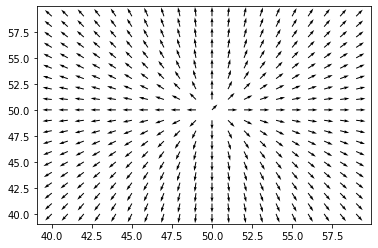

In [4]:
%matplotlib tk
check = IVP([0,3], 'poisson')
check.jacobi(1000)
print('next')
%matplotlib inline
check.efield()

GAUSS-SEIDEL

100
Counter=400 convergence=0.29470690700196656 time=0.024600744247436523s
Counter=800 convergence=0.2541249716176708 time=0.022548437118530273s
Counter=1200 convergence=0.18566686949890254 time=0.0225832462310791s
Counter=1600 convergence=0.12787680837294602 time=0.0223238468170166s
Counter=2000 convergence=0.08634630229067852 time=0.021874427795410156s
Counter=2400 convergence=0.05791408693301037 time=0.02276301383972168s
2547 0.04997345882901527


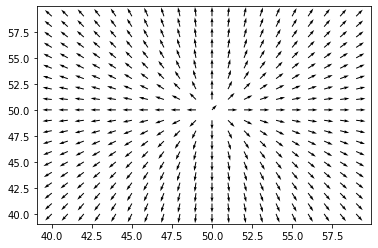

In [6]:
%matplotlib inline
check = IVP([0,3],'poisson')
check.gausspoint()
%matplotlib inline
check.efield()
check.dataefield()

BFIELD

Counter=1000 convergence=15.24982587447812 time=0.023883819580078125s
Counter=2000 convergence=5.772563795373571 time=0.02325725555419922s
Counter=3000 convergence=2.1135220685609966 time=0.024127483367919922s
3744 0.9991746236410108


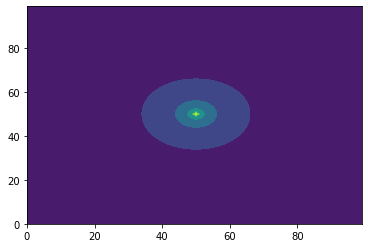

In [119]:
check = IVP([0,3],'poisson')
check.wire()


/tmp/ipykernel_11345/1028578381.py:388: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  positiondata = np.array((x,y, potential, bx,by))
/tmp/ipykernel_11345/1028578381.py:389: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  distancedata = np.array((distance, potential, normb))


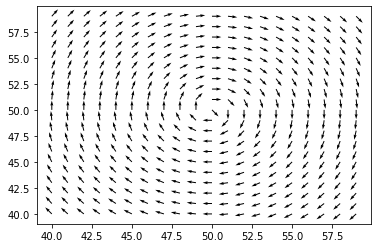

In [120]:
b = check.bfield()
check.databfield()

RELAXATION

Temp=100 convergence=0.33333333073976235 sum1=32.999999988817045  sum2=33.33333331955681  
Temp=200 convergence=0.3332973135081829 sum1=66.33272345172077  sum2=66.66602076522895  
Temp=300 convergence=0.3324068117303369 sum1=99.6337525191374  sum2=99.96615933086774  
Temp=400 convergence=0.3284929096099347 sum1=132.71446892408125  sum2=133.04296183369118  
Temp=500 convergence=0.32011573553043604 sum1=165.1877684138557  sum2=165.50788414938614  
Temp=600 convergence=0.3074012158228072 sum1=196.602623545683  sum2=196.9100247615058  
Temp=100 convergence=0.34006733634441844 sum1=33.66494913856397  sum2=34.00501647490839  
Temp=200 convergence=0.34002305269368094 sum1=67.67092169318474  sum2=68.01094474587842  
Temp=300 convergence=0.33899240482259074 sum1=101.639662442659  sum2=101.9786548474816  
Temp=400 convergence=0.33461866650969796 sum1=135.35914102410726  sum2=135.69375969061696  
Temp=500 convergence=0.3254656542701184 sum1=168.408776906761  sum2=168.73424256103112  
Temp=600 con

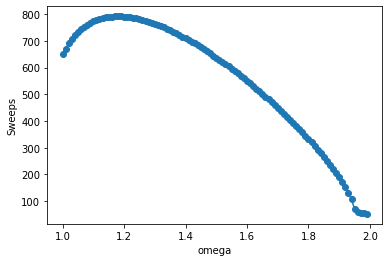

Minimum at 52


In [7]:
check.relax()